In [ ]:
import numpy as np

def load_mats(path, verbose=False):
    """
    Leer archivos .dat
        1ra matriz -> distancias
        2da matriz -> flujos
    """
    try:
        with open(path, "r") as file:
            lines = file.readlines()
            try:
                mat_size = int(lines[0].strip())
                if (verbose): print(f"mat_size={mat_size}")

                n_mats = int((len(lines)-1) / mat_size)
                if (verbose): print(f"nmats={n_mats}")
                mats = np.zeros((n_mats, mat_size, mat_size), dtype=np.int32)
                for idx_mat in range(n_mats):
                    for i in range(1, mat_size+1):
                        elements = list(filter(None, lines[idx_mat*mat_size + i].strip().split(' ')))
                        if elements:
                            if len(elements) != mat_size:
                                print(f"Matriz irregular [{len(elements)} != {mat_size}] en {path} (linea {idx_mat*mat_size + i})\nDetail:\n{elements}")
                                return dict()
                            for j in range(len(elements)):
                                if elements[j]:
                                    mats[idx_mat, i-1, j] = np.int32(elements[j])
                return {"nombre" : path, "distancia" : mats[0, :, :], "flujo" : mats[1, :, :]}
            except ValueError:
                print("ValueError")
            except:
                print(f"Error al parsear {path}")
    except:
        print(f"Archivo {path} no existe")

    return dict()

def save(path, solucion, valor, iteraciones):
    try:
        file = open(path, "w")

        file.write(f"{valor} {iteraciones}\n")
        for el in solucion:
            file.write(f"{el} ")
        file.write("\n")
    except:
        print(f"Unable to write file {path}")

# Funcion objetivo de kevin
def funcion_objetivo(solucion, matD, matF):
    permutado = matF[solucion, :][:, solucion]
    return np.sum(np.multiply(matD, permutado), dtype=np.int32)

def funcion_objetivo_original_QAP(solucion, matD, matF):
    result = 0
    n = matD.shape[0]

    for i in range(n):
        for j in range(n):
                if i != j:
                    result += matD[i, j] * matF[solucion[i] , solucion[j] ]
    return result

def delta_pocha(S, d, f, r, s):
    n = len(S)
    delta_val = 0
    for k in range(n):
        if k == r or k == s:
            continue
        delta_val += (
            d[r][k] * (f[S[r]][S[k]] - f[S[s]][S[k]]) +
            d[k][r] * (f[S[k]][S[r]] - f[S[k]][S[s]]) +
            d[s][k] * (f[S[s]][S[k]] - f[S[r]][S[k]]) +
            d[k][s] * (f[S[k]][S[s]] - f[S[k]][S[r]])
        )
    delta_val += (
        d[r][s] * (f[S[r]][S[s]] - f[S[s]][S[r]]) +
        d[s][r] * (f[S[s]][S[r]] - f[S[r]][S[s]])
    )
    return delta_val

def delta(S, d, f, r, s):
    S = np.asarray(S)
    n = len(S)

    k = np.array([k for k in range(n) if k != r and k != s])

    # Preextraer ubicaciones
    Sr, Ss = S[r], S[s]
    Sk = S[k]

    # Vectorizados
    term1 = d[r, k] * (f[Sr, Sk] - f[Ss, Sk])
    term2 = d[k, r] * (f[Sk, Sr] - f[Sk, Ss])
    term3 = d[s, k] * (f[Ss, Sk] - f[Sr, Sk])
    term4 = d[k, s] * (f[Sk, Ss] - f[Sk, Sr])

    # Suma total de los cuatro vectores
    delta_val = np.sum(term1 + term2 + term3 + term4, dtype=np.int32)

    # Términos fuera del bucle
    delta_val += d[r][s] * (f[Sr][Ss] - f[Ss][Sr]) + d[s][r] * (f[Ss][Sr] - f[Sr][Ss])

    return delta_val

def operador_sublista_aleatoria(solucion, s : int):
    """
    Operador de generacion de vecino -> Sublista Aleatoria de Tamaño Fijo:
    este proceso consiste en generar aleatoriamente dos posiciones
     que determinen una sublista de tamaño s, analizar las asignaciones
    efectuadas entre ambas y reasignarlas aleatoriamente. Se considerarán
    sublistas cíclicas y, por tanto, la posición inicial de la sublista
    no siempre será inferior a la posición final.
    """
    n = len(solucion)
    inicio = np.random.randint(n)

    # Crear los índices cíclicos de la sublista
    indices = [(inicio + i) % n for i in range(s)]

    # Extraer y mezclar la sublista
    sublista = [solucion[i] for i in indices]
    shuffled = sublista.copy()
    while shuffled == sublista:
        np.random.shuffle(shuffled)

    # Reinsertar la sublista mezclada
    nueva_solucion = solucion.copy()
    for idx, val in zip(indices, shuffled):
        nueva_solucion[idx] = val

    return nueva_solucion

def vector_to_str(vct : list) -> str:
    s = " "
    for e in vct:
        s = s + str(e) + " "

    return s

import csv
import os
import pandas as pd

class Logger:

    def __init__(self, ruta_csv, overwrite=True):
        self.ruta_csv = ruta_csv
        self.dataset = None

        # Crear archivo con cabecera
        if overwrite or not os.path.exists(self.ruta_csv):
            with open(self.ruta_csv, mode='w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(["Dataset", "Algoritmo", "Semilla", "Costo", "Evaluaciones", "Solucion"])
        else:
            self.data = pd.read_csv(self.ruta_csv)

    def set_dataset(self, dataset):
        self.dataset = dataset

    def log(self, algoritmo, semilla, costo, evaluaciones, solucion):
        if not self.dataset:
            raise Exception("Dataset not set!")
        fila = [
            self.dataset,
            algoritmo,
            semilla,
            costo,
            evaluaciones,
            solucion
        ]

        with open(self.ruta_csv, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(fila)



In [ ]:
import matplotlib.pyplot as plt

"""
Metricas para SOLO VNS
"""

def error_relativo(valor_medio, mejor_valor):
    re = ( (valor_medio - mejor_valor) / mejor_valor) * 100
    return re

def coeficiente_variacion(std, mean):
    """
    generar histograma para cada problema 25,90,150
    """
    cv = (std / mean) * 100
    return cv


"""
Extrae datos del logger, calcula errores relativos y llama a funciones de visualización.

:param logger: instancia de Logger con .data cargado
:param valor_optimo_dict: diccionario con el mejor valor conocido por dataset, ej:
        {'tai25b.dat': 344355646, 'sko90b.dat': 115534, 'tai150b.dat': 498896643}
"""
logger = Logger("resultados/COMPLETO.csv", False)

if logger.data is None:
    raise Exception("No se han cargado los datos del CSV")



In [ ]:
### Obtener datos

MEJOR_VALOR = {
    'n25' : min(logger.data[logger.data['Dataset'].str.contains("tai25")]['Costo']),
    'n90' : min(logger.data[logger.data['Dataset'].str.contains("sko90")]['Costo']),
    'n150' : min(logger.data[logger.data['Dataset'].str.contains("tai150")]['Costo'])
}

# Medias de coste VNS

dic_costos = dict()
dic_evals = dict()
for s in ["tai25", "sko90", "tai150"]:
    dic_costos[s] = list(logger.data[(logger.data['Dataset'].str.contains(s)) & (logger.data['Algoritmo'] == 'VNS')]['Costo'])
    dic_evals[s] = list(logger.data[(logger.data['Dataset'].str.contains(s)) & (logger.data['Algoritmo'] == 'VNS')]['Evaluaciones'])


In [ ]:
headers = ["", "Tai25b", "", "Sko90", "", "Tai150b"]
subheaders = ["", "Coste", "#Ev.", "Coste", "#Ev.", "Coste"]

print("\\begin{table}[htb]")
print("\\centering")
print("\\begin{tabular}{|c|c|c|c|c|c|}")
print("\\hline")
print(f"     & \\multicolumn{{2}}{{c|}}{{{headers[1]}}} & \\multicolumn{{2}}{{c|}}{{{headers[3]}}} & \\multicolumn{{1}}{{c|}}{{{headers[5]}}} \\\\ \\hline")
print("     & Coste & \\#Ev. & Coste & \\#Ev. & Coste \\\\ \\hline")

for i in range(5):
    fila = f"Ejecución {i+1}"
    for k in ["tai25", "sko90", "tai150"]:
        c = f"{dic_costos[k][i]:,}" if i < len(dic_costos[k]) else ""
        e = f"{dic_evals[k][i]:,}" if i < len(dic_evals[k]) else ""
        fila += f" & {c} & {e}"
    print(f"{fila} \\\\ \\hline")

# Media
fila = "Media"
for k in ["tai25", "sko90", "tai150"]:
    c_mean = np.mean(dic_costos[k]) if dic_costos[k] else ""
    e_mean = np.mean(dic_evals[k]) if dic_evals[k] else ""
    fila += f" & {c_mean:,.1f} & {e_mean:,.1f}"
print(f"{fila} \\\\ \\hline")

# Desviación típica
fila = "Des.Tip. ($\\sigma$)"
for k in ["tai25", "sko90", "tai150"]:
    c_std = np.std(dic_costos[k]) if dic_costos[k] else ""
    e_std = np.std(dic_evals[k]) if dic_evals[k] else ""
    fila += f" & {c_std:,.2f} & {e_std:,.2f}"
print(f"{fila} \\\\ \\hline")

print("\\end{tabular}")
print("\\caption{Resultados detallados de VNS}")
print("\\end{table}")

\begin{table}[htb]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
     & \multicolumn{2}{c|}{Tai25b} & \multicolumn{2}{c|}{Sko90} & \multicolumn{1}{c|}{Tai150b} \\ \hline
     & Coste & \#Ev. & Coste & \#Ev. & Coste \\ \hline
Ejecución 1 & 347,644,233 & 16,250 & 116,534 & 2,267,728 & 505,128,682 & 11,268,342 \\ \hline
Ejecución 2 & 349,949,168 & 24,588 & 116,432 & 2,178,700 & 507,201,578 & 17,072,301 \\ \hline
Ejecución 3 & 366,229,908 & 19,800 & 116,372 & 2,223,035 & 508,794,110 & 16,609,444 \\ \hline
Ejecución 4 & 347,360,879 & 23,045 & 116,836 & 1,879,881 & 508,647,531 & 15,724,937 \\ \hline
Ejecución 5 & 350,999,189 & 24,643 & 116,356 & 2,385,175 & 506,280,085 & 14,458,267 \\ \hline
Media & 352,436,675.4 & 21,665.2 & 116,506.0 & 2,186,903.8 & 507,210,397.2 & 15,026,658.2 \\ \hline
Des.Tip. ($\sigma$) & 7,031,906.41 & 3,228.54 & 176.42 & 168,214.02 & 1,398,041.24 & 2,079,685.93 \\ \hline
\end{tabular}
\caption{Resultados detallados de VNS}
\end{table}


In [ ]:
def print_tabla_global(logger):
    datasets = {
        'tai25': 'Tai25b',
        'sko90': 'Sko90',
        'tai150': 'Tai150b'
    }

    algoritmos = ['Greedy', 'BL Mejor Vecino', 'GRASP', 'ILS', 'VNS']

    optimos = {
        'tai25': 344_355_646,
        'sko90': 115_534,
        'tai150': 498_896_643
    }

    def notacion_cientifica(valor):
        return f"{valor:.2e}"

    print("\\begin{table}[htb]")
    print("\\centering")
    print("\\begin{tabular}{|c|cccc|cccc|cccc|}")
    print("\\hline")
    print("\\textbf{Modelo} & \\multicolumn{4}{c|}{\\textbf{Tai25b}} & \\multicolumn{4}{c|}{\\textbf{Sko90}} & \\multicolumn{4}{c|}{\\textbf{Tai150b}} \\\\ \\hline")
    print("Algoritmo & Mejor & Media & Peor & $\\sigma$ & Mejor & Media & Peor & $\\sigma$ & Mejor & Media & Peor & $\\sigma$ \\\\ \\hline")

    # Fila óptimos
    fila = "Óptimo"
    for clave in ['tai25', 'sko90', 'tai150']:
        fila += f" & - & {optimos[clave]:,} & - & -"
    fila += " \\\\ \\hline"
    print(fila)

    # Resto de algoritmos
    for algoritmo in algoritmos:
        fila = algoritmo.ljust(11)

        for clave in ['tai25', 'sko90', 'tai150']:
            dataset = clave
            df_sub = logger.data[
                (logger.data['Algoritmo'].str.lower().str.contains(algoritmo.lower())) &
                (logger.data['Dataset'].str.contains(dataset))
            ]

            if not df_sub.empty:
                costos = df_sub['Costo'].astype(float).values
                if algoritmo in ['Greedy', 'GRASP', 'ILS']:
                    media = np.mean(costos)
                    fila += f" & - & {media:,.2e} & - & -"
                else:
                    mejor = np.min(costos)
                    media = np.mean(costos)
                    peor = np.max(costos)
                    std = np.std(costos)
                    fila += f" & {notacion_cientifica(mejor)} & {media:,.2e} & {notacion_cientifica(peor)} & {notacion_cientifica(std)}"
            else:
                fila += " & - & x & - & -"

        fila += " \\\\ \\hline"
        print(fila)

    print("\\end{tabular}")
    print("\\caption{Resultados globales del problema QAP.}")
    print("\\end{table}")

def print_tablas_por_dataset(logger):
    algoritmos = ['Greedy', 'BL Mejor Vecino', 'GRASP', 'ILS', 'VNS']

    optimos = {
        'tai25': 344_355_646,
        'sko90': 115_534,
        'tai150': 498_896_643
    }

    nombres = {
        'tai25': 'Tai25b',
        'sko90': 'Sko90',
        'tai150': 'Tai150b'
    }

    for clave_dataset in ['tai25', 'sko90', 'tai150']:
        print("\\begin{table}[htb]")
        print("\\centering")
        print("\\begin{tabular}{|c|c|c|c|c|}")
        print("\\hline")
        print(f"\\textbf{{Modelo}} & \\textbf{{Mejor}} & \\textbf{{Media}} & \\textbf{{Peor}} & $\\sigma$ \\\\ \\hline")

        # Óptimo
        optimo = optimos[clave_dataset]
        print(f"Óptimo & - & {optimo:,} & - & - \\\\ \\hline")

        # Algoritmos
        for algoritmo in algoritmos:
            df_sub = logger.data[
                (logger.data['Algoritmo'].str.lower().str.contains(algoritmo.lower())) &
                (logger.data['Dataset'].str.contains(clave_dataset))
            ]

            if not df_sub.empty:
                costos = df_sub['Costo'].astype(float).values

                if algoritmo in ['Greedy', 'GRASP', 'ILS']:
                    media = np.mean(costos)
                    print(f"{algoritmo} & - & {media:,.1f} & - & - \\\\ \\hline")
                else:
                    mejor = np.min(costos)
                    media = np.mean(costos)
                    peor = np.max(costos)
                    std = np.std(costos)
                    print(f"{algoritmo} & {int(mejor):,} & {media:,.1f} & {int(peor):,} & {std:,.2f} \\\\ \\hline")
            else:
                print(f"{algoritmo} & - & x & - & - \\\\ \\hline")

        print(f"\\end{{tabular}}")
        print(f"\\caption{{Resultados globales para el dataset {nombres[clave_dataset]}}}")
        print("\\end{table}\n")
print_tablas_por_dataset(logger)

\begin{table}[htb]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
\textbf{Modelo} & \textbf{Mejor} & \textbf{Media} & \textbf{Peor} & $\sigma$ \\ \hline
Óptimo & - & 344,355,646 & - & - \\ \hline
Greedy & - & 913,427,707.0 & - & - \\ \hline
BL Mejor Vecino & 368,865,581 & 397,896,312.6 & 458,038,241 & 31,060,788.91 \\ \hline
GRASP & - & 349,785,972.0 & - & - \\ \hline
ILS & - & 345,626,201.0 & - & - \\ \hline
VNS & 347,360,879 & 352,436,675.4 & 366,229,908 & 7,031,906.41 \\ \hline
\end{tabular}
\caption{Resultados globales para el dataset Tai25b}
\end{table}

\begin{table}[htb]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
\textbf{Modelo} & \textbf{Mejor} & \textbf{Media} & \textbf{Peor} & $\sigma$ \\ \hline
Óptimo & - & 115,534 & - & - \\ \hline
Greedy & - & 136,080.0 & - & - \\ \hline
BL Mejor Vecino & 117,440 & 117,927.2 & 118,226 & 299.96 \\ \hline
GRASP & - & 117,226.0 & - & - \\ \hline
ILS & - & 116,280.0 & - & - \\ \hline
VNS & 116,356 & 116,506.0 & 116,836 & 176.42 \\ \hline
\

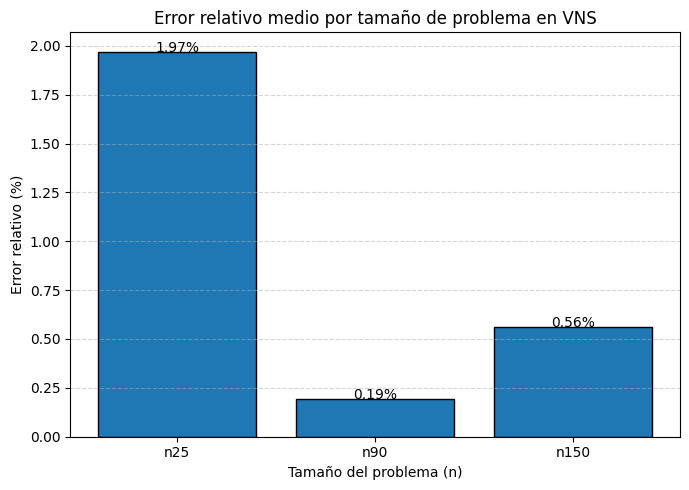

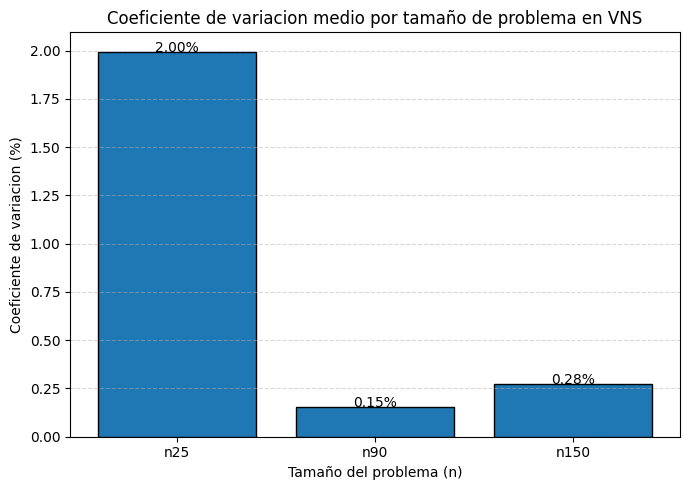

In [ ]:
"""

GRAFICO BARRAS DEL ERROR RELATIVO Y COEFICIENTE DE VARIACION

"""
df_vns = logger.data[logger.data['Algoritmo'] == 'VNS']

vns_data = {
    'n25': df_vns[df_vns['Dataset'].str.contains("tai25")][['Costo', 'Evaluaciones']],
    'n90': df_vns[df_vns['Dataset'].str.contains("sko90")][['Costo', 'Evaluaciones']],
    'n150': df_vns[df_vns['Dataset'].str.contains("tai150")][['Costo', 'Evaluaciones']]
}

vns_stats = dict()
valores_er = []
valores_cv = []
xlabels = []
mean_evaluaciones = []

for clave, grupo in vns_data.items():

    costos = grupo['Costo'].astype(float).values  # Asegurar tipo numérico

    if len(costos) == 0:
        continue  # Saltar si no hay datos

    xlabels.append(clave)

    stats = {
        'n': clave,
        'mean': np.mean(costos),
        'std': np.std(costos),
        'minimum': np.min(costos),
        'maximum': np.max(costos)
    }

    mean_evaluaciones.append(np.mean(grupo['Evaluaciones'].astype(float).values))

    vns_stats[clave] = stats

    valores_er.append(error_relativo(stats['mean'], MEJOR_VALOR[clave]))
    valores_cv.append(coeficiente_variacion(stats['std'], stats['mean']))

plt.figure(figsize=(7, 5))
plt.bar(xlabels, valores_er, edgecolor='black')
# Etiquetas y estilo
plt.title("Error relativo medio por tamaño de problema en VNS")
plt.xlabel("Tamaño del problema (n)")
plt.ylabel("Error relativo (%)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
# Etiquetas encima de las barras
for i, v in enumerate(valores_er):
    plt.text(i, v, f"{v:.2f}%", ha='center')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.bar(xlabels, valores_cv, edgecolor='black')
# Etiquetas y estilo
plt.title("Coeficiente de variacion medio por tamaño de problema en VNS")
plt.xlabel("Tamaño del problema (n)")
plt.ylabel("Coeficiente de variacion (%)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
# Etiquetas encima de las barras
for i, v in enumerate(valores_cv):
    plt.text(i, v, f"{v:.2f}%", ha='center')
plt.tight_layout()
plt.show()

Regresión log-log:
log(E) = -1.7499 + 3.6417 · log(n)
=> E ≈ exp(-1.7499) · n^3.6417


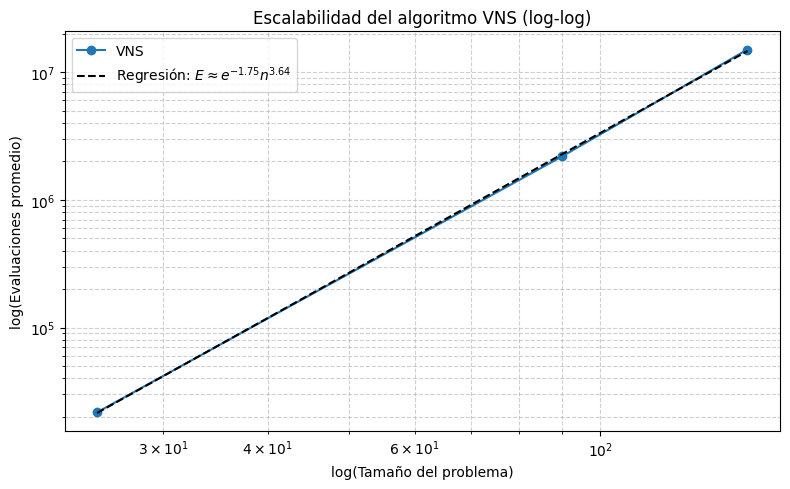

In [ ]:
"""

GRAFICO ESCALABILIDAD
"""

S = np.array([25, 90, 150])
E = np.array(mean_evaluaciones)

def ajustar_regresion_loglog(S, E):
    """
    Calcula los parámetros de regresión log-log: log(E) = _alpha + _beta * log(n)
    :param S: array de tamaños de problema (n)
    :param E: array de evaluaciones promedio
    :return: (alpha, beta)
    """
    logS = np.log(S)
    logE = np.log(E)

    # Ajuste lineal: log(E) = β·log(n) + α
    beta, alpha = np.polyfit(logS, logE, 1)

    print(f"Regresión log-log:")
    print(f"log(E) = {alpha:.4f} + {beta:.4f} · log(n)")
    print(f"=> E ≈ exp({alpha:.4f}) · n^{beta:.4f}")

    return alpha, beta

alpha, beta = ajustar_regresion_loglog(S, E)

"""
# Graficar
plt.figure(figsize=(8, 5))
plt.loglog(S, E, 'o-', label='VNS')
plt.xlabel("log(Tamaño del problema)")
plt.ylabel("log(Evaluaciones promedio)")
plt.title("Escalabilidad del algoritmo VNS (log-log)")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
"""

logS = np.log(S)
logE = np.log(E)
beta, alpha = np.polyfit(logS, logE, 1)
E_pred = np.exp(alpha) * S ** beta


# Gráfico con tu estilo
plt.figure(figsize=(8, 5))
plt.loglog(S, E, 'o-', label='VNS')  # puntos y líneas conectadas
plt.loglog(S, E_pred, 'k--', label=f'Regresión: $E \\approx e^{{{alpha:.2f}}} n^{{{beta:.2f}}}$')

plt.xlabel("log(Tamaño del problema)")
plt.ylabel("log(Evaluaciones promedio)")
plt.title("Escalabilidad del algoritmo VNS (log-log)")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


### EXPERIMENTO GRASP

In [ ]:
def bl_mejor_vecino(seed, matD, matF, funcion_objetivo, delta):
    # Init semilla
    np.random.seed(seed)

    evals = 1

    n_nodes = matD.shape[0]
    mejor_solucion = np.random.permutation(n_nodes)
    mejor_valor = funcion_objetivo(mejor_solucion, matD, matF)
    valor_mejor_vecino = mejor_valor
    seguir = True

    while seguir:
        mejor_i = 0
        mejor_j = 0
        for i in range(n_nodes - 1):
            for j in range(i + 1, n_nodes):
                valor_vecino = mejor_valor - delta(mejor_solucion, matD, matF, i, j)
                #if evals % 10000 == 0: print(evals)
                evals += 1

                if valor_vecino < valor_mejor_vecino:
                    mejor_i = i
                    mejor_j = j
                    valor_mejor_vecino = valor_vecino

        if valor_mejor_vecino < mejor_valor:
            mejor_valor = valor_mejor_vecino
            mejor_solucion[mejor_i], mejor_solucion[mejor_j] = mejor_solucion[mejor_j], mejor_solucion[mejor_i]
        else:
            seguir = False

    return mejor_solucion, valor_mejor_vecino, evals

def bl_primer_mejor(solucion_actual, matD, matF, delta, valor_fo=None, funcion_objetivo=None):
    """
    Se hace la busqueda local del primer mejor
    No hay componentes aleatorias
    """
    n_nodes = matD.shape[0]

    mejor_solucion = solucion_actual
    mejor_valor = valor_fo
    if not valor_fo:
        mejor_valor = funcion_objetivo(mejor_solucion, matD, matF)

    evals = 0

    while True:

        encontrado = False
        for i in range(n_nodes - 1):
            for j in range(i + 1, n_nodes):
                valor_vecino = mejor_valor - delta(mejor_solucion, matD, matF, i, j)
                #valor_vecino = funcion_objetivo(vecino, matD, matF)
                evals += 1
                #print(evals)

                if valor_vecino < mejor_valor:
                    mejor_solucion[i], mejor_solucion[j] = mejor_solucion[j], mejor_solucion[i]
                    mejor_valor = valor_vecino
                    encontrado = True
                    break

            if encontrado:
                break

        if not encontrado:
            break

    return mejor_solucion, mejor_valor, evals

In [ ]:
############### EXPERIMENTO GRASP
def generar_greedy_prob(matD, matF, l : int, seed : float):
    """
    Construye una solución inicial para el QAP usando una heurística greedy probabilística.

    :param flujo: Matriz de flujo entre unidades (numpy array n x n).
    :param distancia: Matriz de distancia entre localizaciones (numpy array n x n).
    :param l: Tamaño de las listas RCL (listas de candidatos restringidas).
    :return: Diccionario representando la asignación {unidad: localización}.
    """
    # Init semilla
    np.random.seed(seed)

    n = matD.shape[0]
    idx_localizaciones_no_asignadas = np.arange(0, n, dtype=np.uint8)
    idx_unidades_no_asignadas = np.arange(0, n, dtype=np.uint8)

    promedio_distancias = np.sum(matD, axis=1)  # Distancia total por localización
    promedio_flujos = np.sum(matF, axis=1) # Flujo total por unidad

    solucion = np.zeros(n, dtype=np.uint8)

    while idx_localizaciones_no_asignadas.size != 0:
        idx_mejores_distancias = sorted(idx_localizaciones_no_asignadas, key=lambda i: promedio_distancias[i])
        l_mejores_distancias = idx_mejores_distancias[:min(l, len(idx_mejores_distancias))]

        idx_mejores_flujos = sorted(idx_unidades_no_asignadas, key=lambda i: -promedio_flujos[i])
        l_mejores_flujos = idx_mejores_flujos[:min(l, len(idx_mejores_flujos))]

        # Selección aleatoria de entre los mejores candidatos
        idx_localizacion_aleatoria = np.random.choice(l_mejores_distancias)
        idx_unidad_aleatoria = np.random.choice(l_mejores_flujos)

        # Segun ChatGPT es asi
        solucion[idx_unidad_aleatoria] = idx_localizacion_aleatoria

        # Se eliminan de las listas
        #idx_localizaciones_no_asignadas.remove(idx_localizacion_aleatoria)
        #idx_unidades_no_asignadas.remove(idx_unidad_aleatoria)

        idx_localizaciones_no_asignadas = np.delete(idx_localizaciones_no_asignadas, np.where(idx_localizaciones_no_asignadas == idx_localizacion_aleatoria))
        idx_unidades_no_asignadas = np.delete(idx_unidades_no_asignadas, np.where(idx_unidades_no_asignadas == idx_unidad_aleatoria))

    return solucion, funcion_objetivo(solucion, matD, matF)

############################### Algoritmo GRASP ###############################################
def GRASP(matD, matF, l, semillas_bl, logger : Logger = None):
    mejor_solucion = None
    mejor_valor = np.inf
    evaluaciones = 0
    soluciones = []

    for seed_bl in semillas_bl:
        solucion_greedy, valor_greedy = generar_greedy_prob(matD, matF, l, seed_bl)
        if (logger != None): logger.log("Greedy Prob", seed_bl, valor_greedy, 1, vector_to_str(solucion_greedy))

        solucion_optimizada, valor_optimizada, eval = bl_primer_mejor(solucion_greedy, matD, matF, delta, valor_fo=valor_greedy)
        if (logger != None): logger.log("BL Primer Mejor", "N/A", valor_optimizada, eval, vector_to_str(solucion_optimizada))
        evaluaciones += eval
        soluciones.append((solucion_optimizada, valor_optimizada))

        if valor_optimizada < mejor_valor:
            mejor_solucion = solucion_optimizada
            mejor_valor = valor_optimizada

    return mejor_solucion, mejor_valor, evaluaciones, soluciones

def GRASP_puro(matD, matF, l, semillas_bl):
    mejor_solucion = None
    mejor_valor = np.inf
    evaluaciones = 0
    soluciones = []

    for seed_bl in semillas_bl:
        solucion_greedy, valor_greedy = generar_greedy_prob(matD, matF, l, seed_bl)
        soluciones.append((solucion_greedy, valor_greedy))

        if valor_greedy < mejor_valor:
            mejor_solucion = solucion_greedy
            mejor_valor = valor_greedy

    return mejor_solucion, mejor_valor, evaluaciones, soluciones

"""
Experimento sobre la Diversidad de Soluciones para GRASP
"""

def distancia_hamming(sol1, sol2):
    return sum(a != b for a, b in zip(sol1, sol2))

tai25 = load_mats("datasets/tai25b.dat")
sko90 = load_mats("datasets/sko90b.dat")
tai150 = load_mats("datasets/tai150b.dat")
GRASP_results = dict()

In [ ]:
for d in [tai25, sko90, tai150]: # Datasets QAP
    n = d['distancia'].shape[0]
    matD = d['distancia']
    matF = d['flujo']

    seeds = [42, 420, 4200, 42000, 80987]
    subdict = dict()
    # GRASP
    l = int(np.round(0.1 * n))
    solucion, valor, _, soluciones = GRASP(matD, matF, l, seeds)

    subdict['solucion'] = solucion
    subdict['valor'] = valor
    #subdict['evaluaciones'] = evaluaciones
    subdict['soluciones'] = soluciones

    GRASP_results[n] = subdict


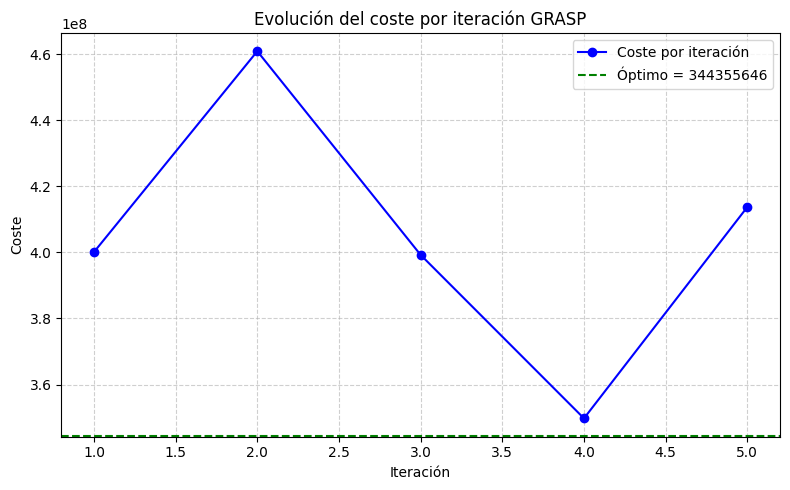

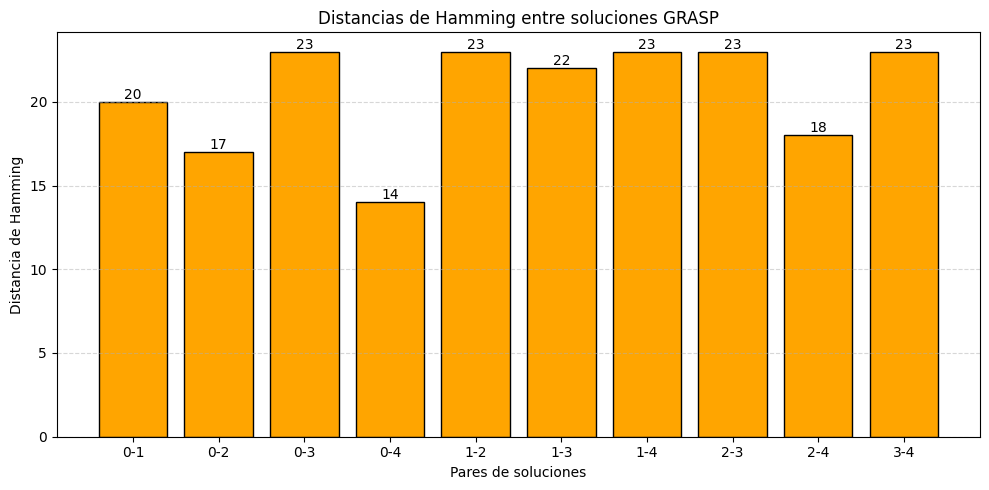

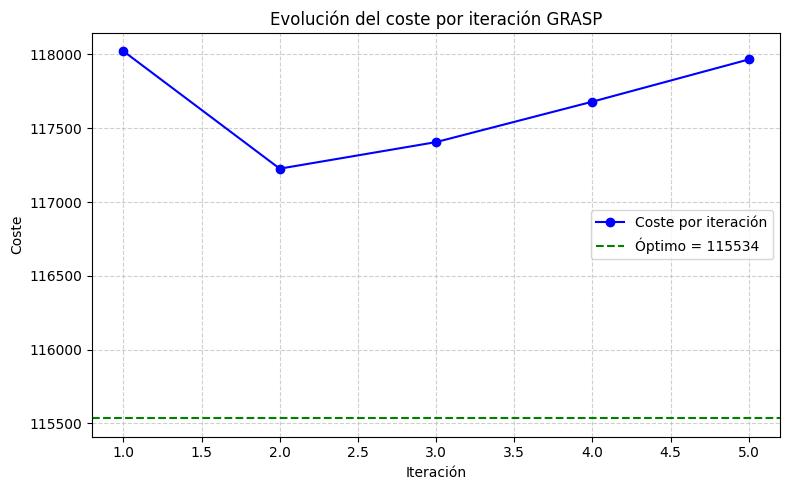

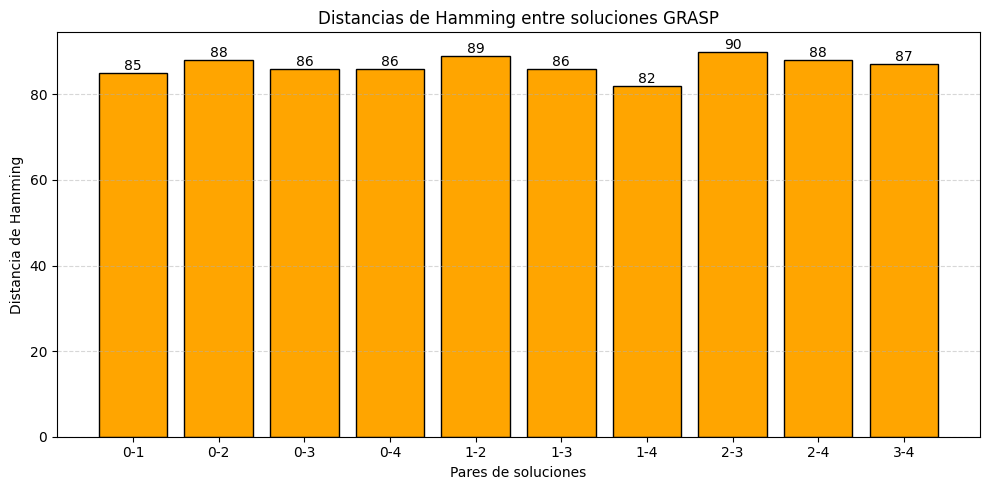

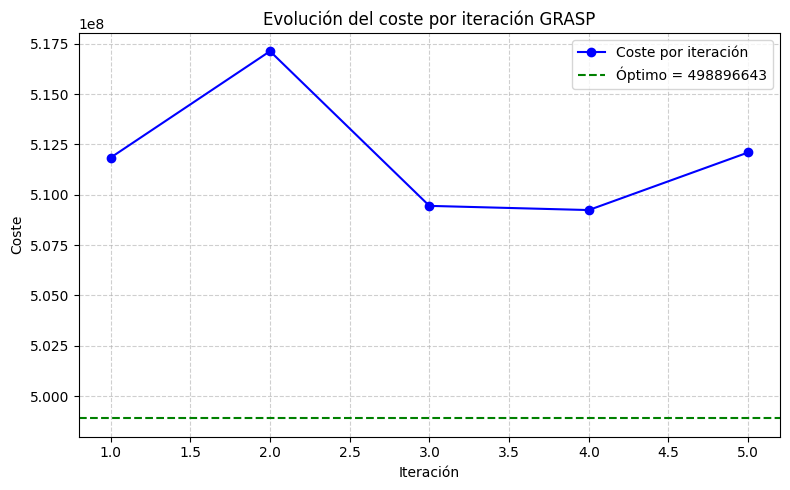

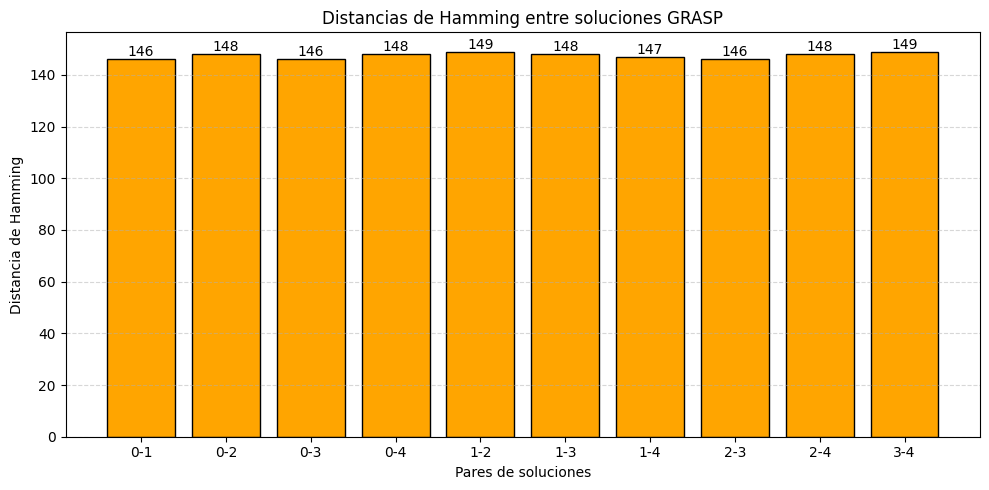

In [ ]:

def plot_evolucion_coste(soluciones_con_valor, optimo=None):
    """
    Dibuja la evolución del valor objetivo por iteración y marca el valor óptimo con una línea horizontal.

    :param soluciones_con_valor: lista de tuplas (solución, valor)
    :param optimo: valor óptimo conocido (opcional)
    """
    valores = [v for _, v in soluciones_con_valor]
    iteraciones = list(range(1, len(valores) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(iteraciones, valores, marker='o', linestyle='-', color='blue', label='Coste por iteración')

    if optimo is not None:
        plt.axhline(y=optimo, color='green', linestyle='--', linewidth=1.5, label=f'Óptimo = {optimo}')

    plt.title("Evolución del coste por iteración GRASP")
    plt.xlabel("Iteración")
    plt.ylabel("Coste")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_distancias_hamming(soluciones_con_valor):
    """
    Muestra las primeras top_n distancias de Hamming entre pares de soluciones, en orden de aparición.
    """
    soluciones = [s for s, _ in soluciones_con_valor]
    distancias = []
    etiquetas = []

    n = len(soluciones)

    for i in range(n):
        for j in range(i + 1, n):
            d = sum(a != b for a, b in zip(soluciones[i], soluciones[j]))
            distancias.append(d)
            etiquetas.append(f"{i}-{j}")

    # Graficar
    plt.figure(figsize=(10, 5))
    plt.bar(etiquetas, distancias, color='orange', edgecolor='black')
    plt.title(f"Distancias de Hamming entre soluciones GRASP")
    plt.xlabel("Pares de soluciones")
    plt.ylabel("Distancia de Hamming")
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Mostrar valor encima de cada barra
    for i, val in enumerate(distancias):
        plt.text(i, val, str(val), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

optimos = {
    25: 344355646,
    90: 115534,
    150: 498896643
}
for n in [25, 90, 150]:
    soluciones_valores = GRASP_results[n]['soluciones']
    plot_evolucion_coste(soluciones_valores, optimo=optimos[n])
    plot_distancias_hamming(soluciones_valores)


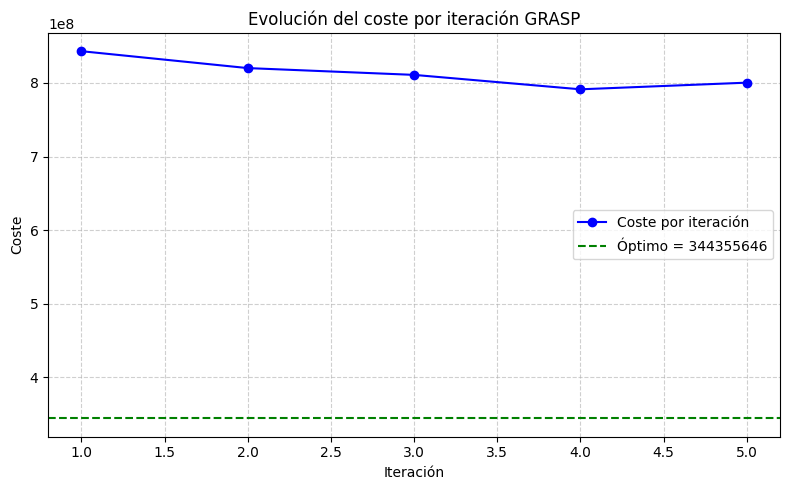

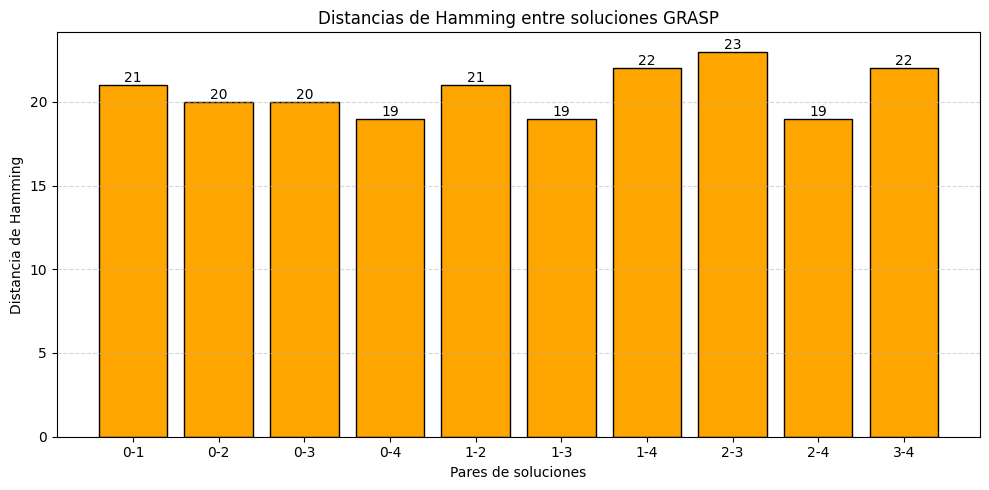

In [ ]:
####### Comparacion entre GRASP y GRASP puro
GRASP_puro_results = dict()

for d in [tai25, sko90, tai150]: # Datasets QAP
    n = d['distancia'].shape[0]
    matD = d['distancia']
    matF = d['flujo']

    seeds = [42, 420, 4200, 42000, 80987]
    subdict = dict()
    # GRASP
    l = int(np.round(0.1 * n))
    solucion, valor, _, soluciones = GRASP_puro(matD, matF, l, seeds)

    subdict['solucion'] = solucion
    subdict['valor'] = valor
    #subdict['evaluaciones'] = evaluaciones
    subdict['soluciones'] = soluciones

    GRASP_puro_results[n] = subdict

soluciones_valores = GRASP_puro_results[25]['soluciones']
plot_evolucion_coste(soluciones_valores, optimo=optimos[25])
plot_distancias_hamming(soluciones_valores)

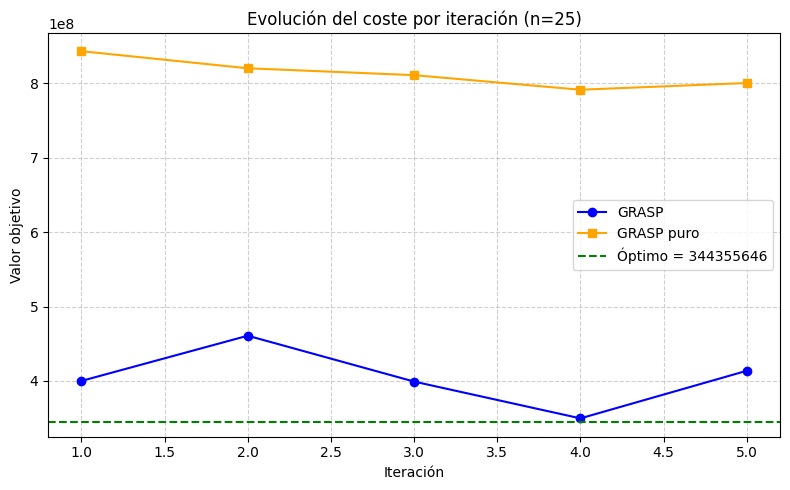

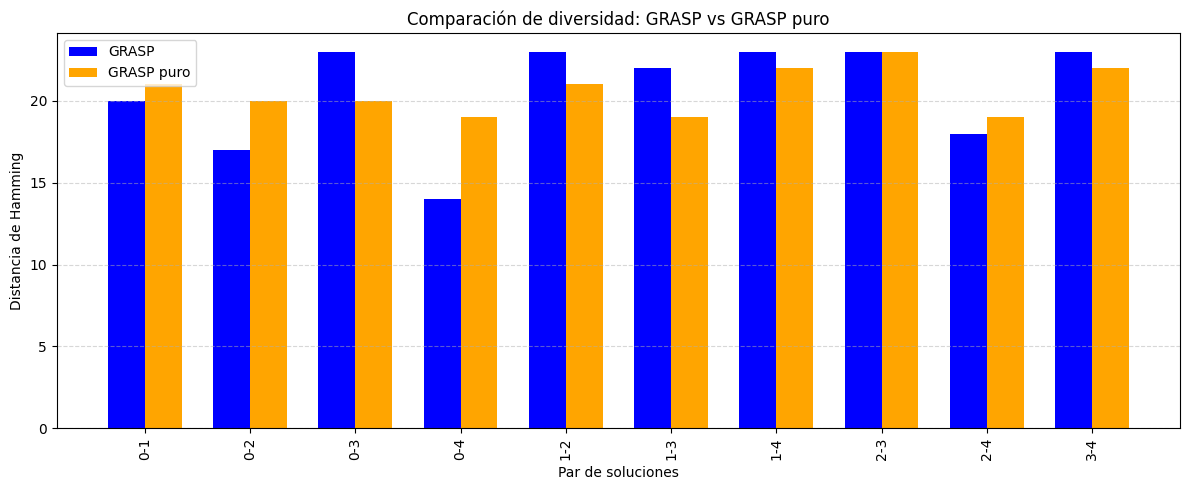

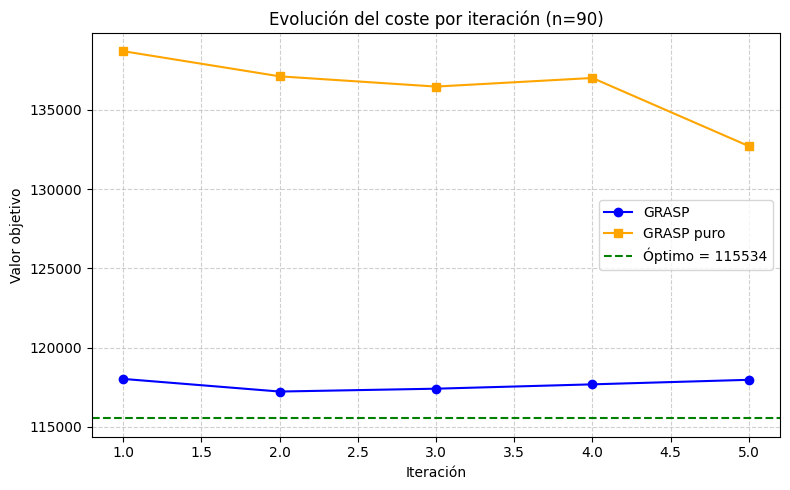

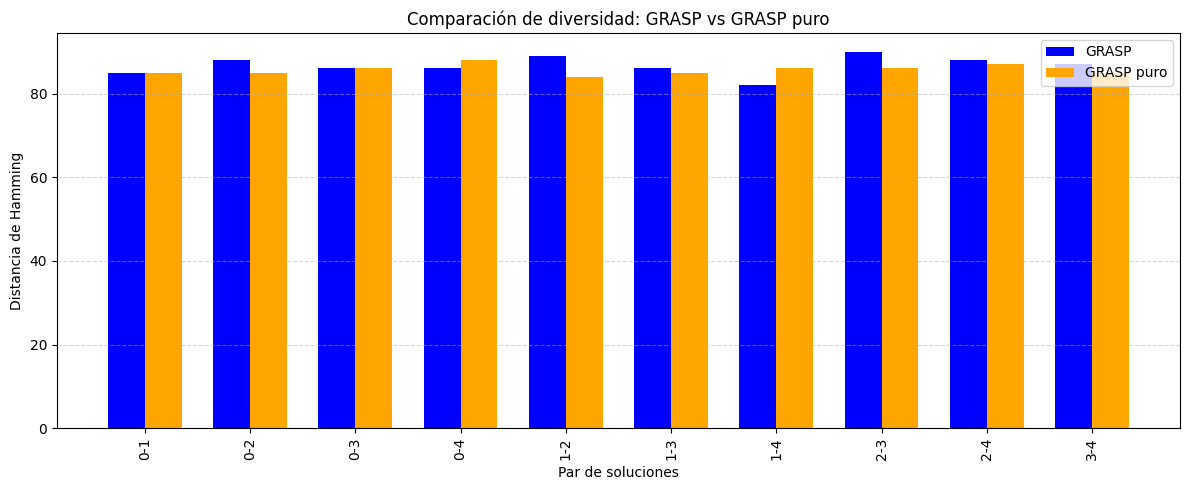

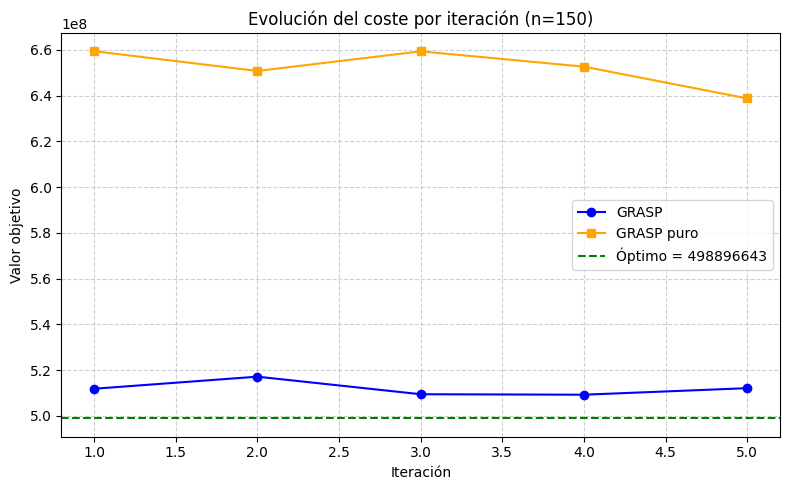

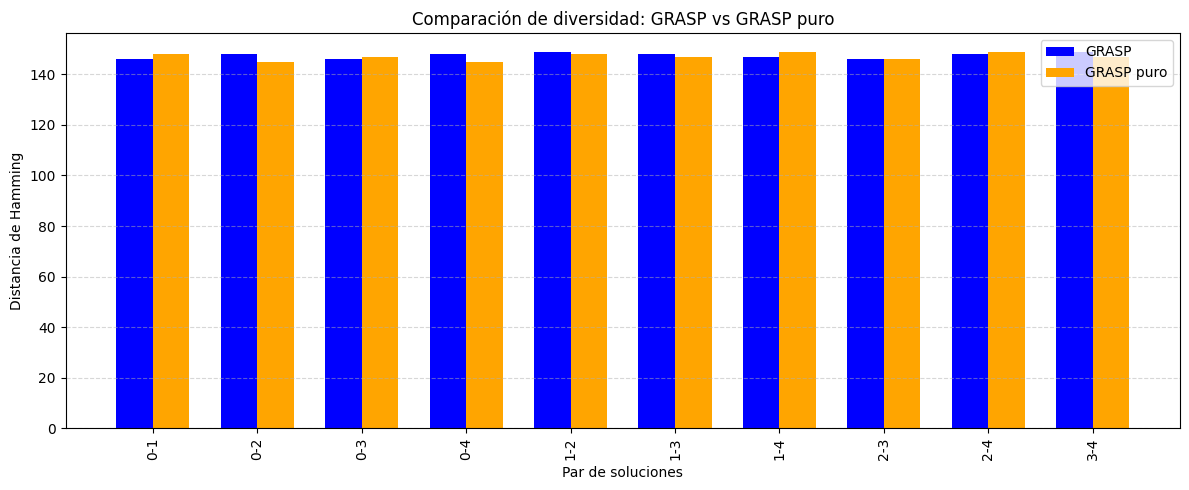

In [ ]:
def plot_evoluciones_comparadas(soluciones_grasp, soluciones_grasp_puro, optimo, titulo=""):
    """
    Dibuja la evolución del coste por iteración para GRASP y GRASP puro, con línea de óptimo.

    :param soluciones_grasp: lista de (solución, valor) para GRASP+BL
    :param soluciones_grasp_puro: lista de (solución, valor) para GRASP puro
    :param optimo: valor óptimo conocido
    :param titulo: título opcional del gráfico
    """
    valores_grasp = [v for _, v in soluciones_grasp]
    valores_puro = [v for _, v in soluciones_grasp_puro]
    iteraciones = list(range(1, len(valores_grasp) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(iteraciones, valores_grasp, marker='o', linestyle='-', label='GRASP', color='blue')
    plt.plot(iteraciones, valores_puro, marker='s', linestyle='-', label='GRASP puro', color='orange')
    plt.axhline(y=optimo, color='green', linestyle='--', label=f'Óptimo = {optimo}')

    plt.title(f"Evolución del coste por iteración {titulo}")
    plt.xlabel("Iteración")
    plt.ylabel("Valor objetivo")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_comparacion_diversidad_hamming(soluciones_grasp, soluciones_grasp_puro):
    """
    Muestra distancias de Hamming agrupadas por par de soluciones, comparando GRASP y GRASP puro.
    Se asume que ambos sets tienen el mismo número de soluciones y en el mismo orden.
    """
    sols_g = [s for s, _ in soluciones_grasp]
    sols_p = [s for s, _ in soluciones_grasp_puro]

    assert len(sols_g) == len(sols_p), "GRASP y GRASP puro deben tener el mismo número de soluciones."

    etiquetas = []
    valores_grasp = []
    valores_puro = []

    n = len(sols_g)
    for i in range(n):
        for j in range(i + 1, n):
            etiqueta = f"{i}-{j}"
            etiquetas.append(etiqueta)
            valores_grasp.append(sum(a != b for a, b in zip(sols_g[i], sols_g[j])))
            valores_puro.append(sum(a != b for a, b in zip(sols_p[i], sols_p[j])))

    x = np.arange(len(etiquetas))  # posiciones
    width = 0.35  # ancho de barra

    plt.figure(figsize=(max(12, len(x) * 0.4), 5))
    plt.bar(x - width/2, valores_grasp, width, label='GRASP', color='blue')
    plt.bar(x + width/2, valores_puro, width, label='GRASP puro', color='orange')

    plt.xticks(x, etiquetas, rotation=90)
    plt.xlabel("Par de soluciones")
    plt.ylabel("Distancia de Hamming")
    plt.title("Comparación de diversidad: GRASP vs GRASP puro")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


for n in [25, 90, 150]:
    sols_grasp = GRASP_results[n]['soluciones']
    sols_puro = GRASP_puro_results[n]['soluciones']

    plot_evoluciones_comparadas(sols_grasp, sols_puro, optimo=optimos[n], titulo=f"(n={n})")
    plot_comparacion_diversidad_hamming(sols_grasp, sols_puro)